In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_path = 'data/I88N-processed/'

# Initialization

## Sample dates, split train/test dataset

In [3]:
dates = pd.read_csv(base_path + 'available_dates.csv')
dates = np.array(dates['0'].values.tolist())
dates = np.array(list(map(lambda x: x.split('-')[1] + '/' + x.split('-')[2] + '/' + x.split('-')[0], dates)))

We want to sample dates in June.

In [4]:
dates = dates[(dates > '05/31/2017') & (dates < '07/01/2017')]

In [5]:
dates_train = np.random.choice(dates, 45, replace=True)
dates_train.sort()
dates_test = np.array(sorted(set(dates).difference(set(dates_train.tolist()))))

In [6]:
len(dates), len(dates_train), len(dates_test), dates_train[0:3], dates_test[0:3]

(29,
 45,
 4,
 array(['06/01/2017', '06/03/2017', '06/03/2017'], dtype='<U10'),
 array(['06/02/2017', '06/08/2017', '06/21/2017'], dtype='<U10'))

## Loading severity data

In [7]:
severity_data = pd.read_csv(base_path + 'severity_params.csv')
severity_data.rename(columns={'Unnamed: 0':'datetime'}, inplace=True)

In [8]:
sev_datetimes = severity_data['datetime'].values

In [9]:
sev_dates = []
sev_times = []
for x in sev_datetimes:
    d, t = x.split(' ')
    sev_dates.append(d)
    sev_times.append(t)

In [10]:
severity_data['Date'] = sev_dates
severity_data['Time'] = sev_times

In [11]:
severity_data = severity_data.loc[~severity_data['Date'].isin(['2017-06-15'])]

In [12]:
lambda_max = severity_data['LambdaMax'].values
sigma = severity_data['Sigma'].values
tau = severity_data['Tau'].values
impact = severity_data['Impact'].values

In [13]:
severity_data.head(3)

,datetime,ID,LambdaMax,Sigma,Tau,Impact,Incident,Date,Time
0,2017-06-01 00:00:00,408907,NaN,NaN,NaN,0.021267,0.0,2017-06-01,00:00:00
1,2017-06-01 00:05:00,408907,NaN,NaN,NaN,0.017058,0.0,2017-06-01,00:05:00
2,2017-06-01 00:10:00,408907,NaN,NaN,0.0,0.015338,0.0,2017-06-01,00:10:00


In [14]:
lambda_max = [0 if np.isnan(x) else x for x in lambda_max]
sigma = [0 if np.isnan(x) else x for x in sigma]
tau = [0 if np.isnan(x) else x for x in tau]

In [15]:
severity_data['LambdaMax'] = lambda_max
severity_data['Sigma'] = sigma
severity_data['Tau'] = tau

## Loading speed, flow, occupancy, and stations

In [16]:
raw = pd.read_csv(base_path + 'concat_no_holes/concat.csv')

In [17]:
# select raw that is sampled
raw_all = raw.loc[raw['Date'].isin(dates)]

In [18]:
raw_all['LambdaMax'] = lambda_max
raw_all['Sigma'] = sigma
raw_all['Tau'] = tau
raw_all['Impact'] = impact

/home/hylei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/hylei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/hylei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [19]:
raw_test = raw_all.loc[raw['Date'].isin(dates_test)]
stations = np.array(raw_all['Station ID'].unique().tolist())

In [20]:
raw_all.head(3)

,Station ID,datetime,Occupancy,Flow,Speed,Date,Time,idx,LambdaMax,Sigma,Tau,Impact
8640,408907,2017-06-01 00:00:00,0.5,22.0,69.5,06/01/2017,00:00,42322,0.0,0.0,0.0,0.021267
8641,408907,2017-06-01 00:05:00,0.5,22.0,69.1,06/01/2017,00:05,42323,0.0,0.0,0.0,0.017058
8642,408907,2017-06-01 00:10:00,0.5,23.0,68.9,06/01/2017,00:10,42324,0.0,0.0,0.0,0.015338


In [21]:
# special construction of raw_train, because the dates are sampled with replacement
raw_train = pd.DataFrame()
duplicate_id = 0
for i in range(0, len(dates_train)):
    if i > 0:
        if dates_train[i] == dates_train[i-1]:
            duplicate_id += 1
        else:
            duplicate_id = 0
    df_date = raw_all.loc[raw_all['Date'] == dates_train[i]]
    df_date = df_date.assign(duplicateIdx=duplicate_id)
    raw_train = raw_train.append(df_date)
sorterIdx = dict( zip(stations, range(len(stations))) )
raw_train['stationSorterIdx'] = raw_train['Station ID'].map(sorterIdx)
raw_train = raw_train.sort_values(['stationSorterIdx', 'duplicateIdx', 'datetime'], ascending=[True, True, True])
raw_train.drop(['duplicateIdx', 'stationSorterIdx', 'idx'], axis=1, inplace=True)

In [22]:
len(raw_train.index)

1321920

In [23]:
var_names = ['Speed', 'Flow', 'Occupancy']

### Construct road segments

In [24]:
road_segments = list()
for i in range(len(stations) - 1):
    road_segments.append(tuple([stations[i], stations[i+1]]))

## Loading incidents

In [25]:
raw_incidents = pd.read_csv(base_path + 'valid_incidents.csv')

In [26]:
raw_incidents_all = raw_incidents.loc[raw_incidents['Date'].isin(dates)]
raw_incidents_train = raw_incidents_all.loc[raw_incidents_all['Date'].isin(dates_train)]
raw_incidents_test = raw_incidents_all.loc[raw_incidents_all['Date'].isin(dates_test)]

In [27]:
svm_pos_timestamps = pd.read_csv(base_path + 'svm_pos_instances.csv')

In [28]:
svm_pos_timestamps_train = svm_pos_timestamps.loc[svm_pos_timestamps['Date'].isin(dates_train)]
svm_pos_timestamps_test = svm_pos_timestamps.loc[svm_pos_timestamps['Date'].isin(dates_test)]

In [29]:
svm_pos_timestamps.head(3)

,Upstream,Downstream,Date,Time
0,408907,400951,01/22/2017,20:30
1,408907,400951,01/22/2017,20:35
2,408907,400951,01/22/2017,20:40


In [30]:
svm_incident_dates_train = svm_pos_timestamps_train['Date'].unique().tolist()
svm_normal_dates_train = list(set(dates_train).difference(svm_incident_dates_train))

In [31]:
len(svm_incident_dates_train), len(svm_normal_dates_train)

(25, 0)

## Progress message formatting

In [32]:
def fraction_msg(present, total):
    return '[{}/{}]'.format(present, total)

# Train: TSA-DES forecasting

In [33]:
def DES_rmse(alpha, var_series):
    len_series = len(var_series)
    
    beta = round(1. - alpha, 3)

    sse = 0.
    s1 = np.mean(var_series[:10])
    s2 = s1
    
    for i in range(11, len_series - 1):
        s1 = alpha * var_series[i] + beta * s1
        s2 = alpha * s1 + beta * s2
        y_next = 2 * s1 - s2 + alpha / beta * (s1 - s2)
        sse += (var_series[i+1] - y_next) ** 2
    
    return np.sqrt( sse / (len_series - 12) )

## Tune best alphas for each station

In [34]:
import multiprocessing as mp

In [35]:
# input: stations, raw training data (includ. incidents), rule to update alphas
# output: a dictionary containing stations, and stations' best alphas
def compute_best_alphas(stations, raw_train, raw_incidents_train, dates_train, num_grids, DES_rmse, fraction_msg):
    best_alphas = {
    'Station ID': [],
    'Speed': [],
    'Flow': [],
    'Occupancy': []
    }
    pid = mp.current_process().pid
    for i, station in enumerate(stations):
        best_alphas['Station ID'].append(station)

        # update current training station dataframe, the training data is normal day's data
        abnormal_dates_station = raw_incidents_train.loc[(raw_incidents_train['Upstream'] == station) | (raw_incidents_train['Downstream'] == str(station))]['Date'].unique()
        normal_dates_train = np.array(list(set(dates_train).difference(set(abnormal_dates_station))))
        df_train_station = raw_train.loc[(raw_train['Station ID'] == station) & (raw_train['Date'].isin(normal_dates_train))]

        print("{} {} Tuning alphas for station {}...".format(pid, fraction_msg(i+1, len(stations)), station))
        for var_name in var_names:
            # print("    " + var_name + "...")
            var_series = df_train_station[var_name].values
            len_series = len(var_series)

            # setting up alphas
            alphas = np.arange(num_grids) * 1. / num_grids

            # save the historical best alpha by rmse
            best_rmse = float("inf")
            best_alpha = 0.

            # for each alpha, perform exponential smoothing, and compute RMSE
            for alpha in alphas:
                rmse = DES_rmse(alpha, var_series)

                # compare, and decide whether to update best alpha
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_alpha = alpha

            # finally, save the best alpha for the variable at this station
            best_alphas[var_name].append(best_alpha)

        # print trained alphas for each station
        # print(best_alphas['Station ID'][i], best_alphas['Speed'][i], best_alphas['Flow'][i], best_alphas['Occupancy'][i])
    print("Process {} has finished alpha tuning.".format(pid))
    return best_alphas

In [36]:
pool = mp.Pool(processes=8)
num_grids = 100
results = [pool.apply_async(compute_best_alphas, args=(stations[13 * i: 13 * i + 13], raw_train, raw_incidents_train, dates_train, num_grids, DES_rmse, fraction_msg)) for i in range(0, 8)]
pool.close()
pool.join()

6851 [1/13] Tuning alphas for station 408907...
6852 [1/13] Tuning alphas for station 400088...
6853 [1/13] Tuning alphas for station 408755...
6854 [1/13] Tuning alphas for station 400137...
6855 [1/13] Tuning alphas for station 400611...
6856 [1/13] Tuning alphas for station 400275...
6857 [1/13] Tuning alphas for station 400333...
6858 [1/11] Tuning alphas for station 400980...
6852 [2/13] Tuning alphas for station 402288...
6851 [2/13] Tuning alphas for station 400951...
6853 [2/13] Tuning alphas for station 402802...
6854 [2/13] Tuning alphas for station 400716...
6856 [2/13] Tuning alphas for station 400939...
6855 [2/13] Tuning alphas for station 400928...
6858 [2/11] Tuning alphas for station 401333...
6857 [2/13] Tuning alphas for station 410363...
6852 [3/13] Tuning alphas for station 413026...
6851 [3/13] Tuning alphas for station 400057...
6854 [3/13] Tuning alphas for station 401545...
6853 [3/13] Tuning alphas for station 408756...
6856 [3/13] Tuning alphas for station 40

In [37]:
exec_results = []
for proc in results:
    exec_results.append(proc.get())

In [38]:
best_alphas = {
    'Station ID': [],
    'Speed': [],
    'Flow': [],
    'Occupancy': []
}
for dict_best_alphas in exec_results:
    for key in best_alphas.keys():
        best_alphas[key].extend(dict_best_alphas[key])

In [39]:
best_alphas

{'Station ID': [408907,
  400951,
  400057,
  400147,
  400343,
  401560,
  400045,
  400122,
  401541,
  402281,
  402283,
  402285,
  402286,
  400088,
  402288,
  413026,
  401464,
  401489,
  401538,
  402290,
  402292,
  401643,
  402800,
  402828,
  407219,
  402789,
  408755,
  402802,
  408756,
  400189,
  400309,
  400417,
  400249,
  401639,
  400662,
  400141,
  400761,
  400490,
  401888,
  400137,
  400716,
  401545,
  401011,
  400674,
  400539,
  400534,
  401062,
  401529,
  401613,
  400536,
  400488,
  401561,
  400611,
  400928,
  400284,
  400041,
  408133,
  408135,
  417665,
  412637,
  417666,
  408134,
  400685,
  401003,
  400898,
  400275,
  400939,
  400180,
  400529,
  400990,
  400515,
  400252,
  400788,
  401517,
  401871,
  400574,
  401629,
  400422,
  400333,
  410363,
  400360,
  400955,
  400495,
  400608,
  400949,
  400678,
  400341,
  400607,
  400094,
  400682,
  408138,
  400980,
  401333,
  404746,
  401142,
  400218,
  400983,
  400765,
  4008

In [40]:
best_alphas_df = pd.DataFrame(best_alphas)
best_alphas_df.to_csv(base_path + 'smaller_sample/best_alphas.csv', index=False)

## Using the tuned alphas to predict training traffic variables

In [41]:
# initialization
# initialize prediction dictionary
pred_dict_train = dict()
for var_name in var_names:
    pred_dict_train[var_name] = []

for i, station in enumerate(stations):
    print("{} Start time series prediction (DES) at station {}...".format(fraction_msg(i+1, len(stations)), station))
    df_train_station = raw_train.loc[raw_train["Station ID"] == station]
    
    # formulate predictions of speed, flow and occupancy for the station
    for var_name in var_names:
        print("    {}...".format(var_name))
        var_series = df_train_station[var_name].values
        len_series = len(var_series)
        # initialize s1, s2, and y
        s1 = np.mean(var_series[:10])
        s2 = s1
        y = [0.] * len_series
        # get the best alpha
        var_best_alpha = best_alphas_df.loc[best_alphas_df["Station ID"] == station][var_name].values[0]
        beta = 1. - var_best_alpha

        for t in range(11, len_series - 1):
            s1 = var_best_alpha * var_series[t] + beta * s1
            s2 = var_best_alpha * s1 + beta * s2
            y[t+1] = round(2 * s1 - s2 + var_best_alpha / beta * (s1 - s2), 2)

        # save the predictions to a dictionary
        pred_dict_train[var_name].extend(y)
    print("End prediction at station {}.".format(station))

[1/102] Start time series prediction (DES) at station 408907...
    Speed...
    Flow...
    Occupancy...
End prediction at station 408907.
[2/102] Start time series prediction (DES) at station 400951...
    Speed...
    Flow...
    Occupancy...
End prediction at station 400951.
[3/102] Start time series prediction (DES) at station 400057...
    Speed...
    Flow...
    Occupancy...
End prediction at station 400057.
[4/102] Start time series prediction (DES) at station 400147...
    Speed...
    Flow...
    Occupancy...
End prediction at station 400147.
[5/102] Start time series prediction (DES) at station 400343...
    Speed...
    Flow...
    Occupancy...
End prediction at station 400343.
[6/102] Start time series prediction (DES) at station 401560...
    Speed...
    Flow...
    Occupancy...
End prediction at station 401560.
[7/102] Start time series prediction (DES) at station 400045...
    Speed...
    Flow...
    Occupancy...
End prediction at station 400045.
[8/102] Start time s

    Occupancy...
End prediction at station 417665.
[60/102] Start time series prediction (DES) at station 412637...
    Speed...
    Flow...
    Occupancy...
End prediction at station 412637.
[61/102] Start time series prediction (DES) at station 417666...
    Speed...
    Flow...
    Occupancy...
End prediction at station 417666.
[62/102] Start time series prediction (DES) at station 408134...
    Speed...
    Flow...
    Occupancy...
End prediction at station 408134.
[63/102] Start time series prediction (DES) at station 400685...
    Speed...
    Flow...
    Occupancy...
End prediction at station 400685.
[64/102] Start time series prediction (DES) at station 401003...
    Speed...
    Flow...
    Occupancy...
End prediction at station 401003.
[65/102] Start time series prediction (DES) at station 400898...
    Speed...
    Flow...
    Occupancy...
End prediction at station 400898.
[66/102] Start time series prediction (DES) at station 400275...
    Speed...
    Flow...
    Occupancy

In [42]:
raw_train = raw_train.assign(Pred_Speed=pred_dict_train['Speed'], Pred_Flow=pred_dict_train['Flow'], Pred_Occupancy=pred_dict_train['Occupancy'])

## Using the tuned alphas to predict testing traffic variables

In [43]:
# initialization
# initialize prediction dictionary
pred_dict_test = dict()
for var_name in var_names:
    pred_dict_test[var_name] = []

for i, station in enumerate(stations):
    print("{} Start time series prediction (DES) at station {}...".format(fraction_msg(i+1, len(stations)), station))
    df_test_station = raw_test.loc[raw_test["Station ID"] == station]
    
    # formulate predictions of speed, flow and occupancy for the station
    for var_name in var_names:
        print("    {}...".format(var_name))
        var_series = df_test_station[var_name].values
        len_series = len(var_series)
        # initialize s1, s2, and y
        s1 = np.mean(var_series[:10])
        s2 = s1
        y = [0.] * len_series
        # get the best alpha
        var_best_alpha = best_alphas_df.loc[best_alphas_df["Station ID"] == station][var_name].values[0]
        beta = 1. - var_best_alpha

        num_batches = int(len_series / 288)
        for j in range(num_batches):
            base_idx = 288 * j
            for t in range(base_idx + 11, base_idx + 287):
                s1 = var_best_alpha * var_series[t] + beta * s1
                s2 = var_best_alpha * s1 + beta * s2
                y[t+1] = round(2 * s1 - s2 + var_best_alpha / beta * (s1 - s2), 2)

        # save the predictions to a dictionary
        pred_dict_test[var_name].extend(y)
    print("Finished forecasting at station {}.".format(station))
print("Finished forecasting for the test dataset.")

[1/102] Start time series prediction (DES) at station 408907...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 408907.
[2/102] Start time series prediction (DES) at station 400951...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 400951.
[3/102] Start time series prediction (DES) at station 400057...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 400057.
[4/102] Start time series prediction (DES) at station 400147...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 400147.
[5/102] Start time series prediction (DES) at station 400343...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 400343.
[6/102] Start time series prediction (DES) at station 401560...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 401560.
[7/102] Start time series prediction (DES) at station 400045...
    Speed...
    Flow...
    Occupancy...
Finished forecasti

    Occupancy...
Finished forecasting at station 417665.
[60/102] Start time series prediction (DES) at station 412637...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 412637.
[61/102] Start time series prediction (DES) at station 417666...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 417666.
[62/102] Start time series prediction (DES) at station 408134...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 408134.
[63/102] Start time series prediction (DES) at station 400685...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 400685.
[64/102] Start time series prediction (DES) at station 401003...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 401003.
[65/102] Start time series prediction (DES) at station 400898...
    Speed...
    Flow...
    Occupancy...
Finished forecasting at station 400898.
[66/102] Start time series prediction (DES) at station 400275

In [44]:
raw_test = raw_test.assign(Pred_Speed=pred_dict_test['Speed'], Pred_Flow=pred_dict_test['Flow'], Pred_Occupancy=pred_dict_test['Occupancy'])

In [45]:
raw_test.tail(3)

,Station ID,datetime,Occupancy,Flow,Speed,Date,Time,idx,LambdaMax,Sigma,Tau,Impact,Pred_Speed,Pred_Flow,Pred_Occupancy
6531261,401471,2017-06-25 23:45:00,0.7,23.0,67.5,06/25/2017,23:45,3200589,-0.009455,0.0,0.0,0.068004,67.35,25.21,0.67
6531262,401471,2017-06-25 23:50:00,0.6,23.0,67.6,06/25/2017,23:50,3200590,-0.008220,0.0,0.0,0.070743,67.43,22.24,0.68
6531263,401471,2017-06-25 23:55:00,0.6,23.0,67.5,06/25/2017,23:55,3200591,-0.008220,0.0,0.0,0.069673,67.54,21.72,0.60


# Train: SVM

In [46]:
import datetime as dt

Note that we need to scale train and test dataset with the same factors.

## Train: feature vectors

### Train: feature vectors - negative

In [47]:
neg_times = raw_train['Time'].unique().tolist()[14:]

In [48]:
neg_sample_dates = np.random.choice(dates_train, 14, replace=False)

In [49]:
svm_incidents_sample = svm_pos_timestamps_train.loc[svm_pos_timestamps_train['Date'].isin(neg_sample_dates)]

In [50]:
X_neg_train = []
num_segments = len(road_segments)
count_date = 0
for neg_sample_date in neg_sample_dates:
    count_date += 1
    print("{} Negative feature vectors at date {}:".format(fraction_msg(count_date, len(neg_sample_dates)), neg_sample_date))
    
    for i, seg in enumerate(road_segments):
        B, E = seg
        df_neg_train_BE = raw_train.loc[((raw_train["Station ID"] == B) | (raw_train["Station ID"] == E)) & (raw_train["Date"] == neg_sample_date)]
        svm_incidents_sample_BE = svm_incidents_sample.loc[svm_incidents_sample['Upstream'] == B]
        sample_neg_times = np.random.choice(neg_times, 24)
        
        if (i+1) % 20 == 0:
            print("    {} Start constructing feature vectors for road segment s_{},{}...".format(fraction_msg(i+1, num_segments), B, E))
            print("        Total number of vectors: {}".format(len(sample_neg_times)))
        
        for neg_t in sample_neg_times:
            # check if current time is incident time
            if len(svm_incidents_sample_BE.loc[svm_incidents_sample_BE['Time'] == neg_t].index) != 0:
                continue

            feature_t = []
            neg_dt_timestamp = pd.Timestamp(neg_sample_date + ' ' + neg_t + ':00')

            B_lags = []
            for j in range(5):
                B_lags.append(neg_dt_timestamp - dt.timedelta(minutes=j*5))
            B_lags = list(map(lambda x: x.strftime('%H:%M') , B_lags))
            E_lags = B_lags[0:3]

            # upstream features
            for t_lag in B_lags:
                df_dt_lag = df_neg_train_BE.loc[(df_neg_train_BE["Station ID"] == B) & (df_neg_train_BE["Time"] == t_lag)]

                speed_B_t = df_dt_lag["Speed"].values[0]
                flow_B_t = df_dt_lag["Flow"].values[0]
                occ_B_t = df_dt_lag["Occupancy"].values[0]

                speed_pred_B_t = df_dt_lag["Pred_Speed"].values[0]
                flow_pred_B_t = df_dt_lag["Pred_Flow"].values[0]
                occ_pred_B_t = df_dt_lag["Pred_Occupancy"].values[0]
                
                lambda_max_B_t = df_dt_lag["LambdaMax"].values[0]
                sigma_B_t = df_dt_lag["Sigma"].values[0]
                tau_B_t = df_dt_lag["Tau"].values[0]
                impact_B_t = df_dt_lag["Impact"].values[0]

                feature_t.extend([speed_B_t, flow_B_t, occ_B_t, 
                                  speed_pred_B_t, flow_pred_B_t, occ_pred_B_t, 
                                  speed_B_t - speed_pred_B_t, flow_B_t - flow_pred_B_t, occ_B_t - occ_pred_B_t, 
                                  lambda_max_B_t, sigma_B_t, tau_B_t, impact_B_t])

            # downstream features
            for t_lag in E_lags:
                df_dt_lag = df_neg_train_BE.loc[(df_neg_train_BE["Station ID"] == E) & (df_neg_train_BE["Time"] == t_lag)]

                speed_E_t = df_dt_lag["Speed"].values[0]
                flow_E_t = df_dt_lag["Flow"].values[0]
                occ_E_t = df_dt_lag["Occupancy"].values[0]

                speed_pred_E_t = df_dt_lag["Pred_Speed"].values[0]
                flow_pred_E_t = df_dt_lag["Pred_Flow"].values[0]
                occ_pred_E_t = df_dt_lag["Pred_Occupancy"].values[0]

                lambda_max_E_t = df_dt_lag["LambdaMax"].values[0]
                sigma_E_t = df_dt_lag["Sigma"].values[0]
                tau_E_t = df_dt_lag["Tau"].values[0]
                impact_E_t = df_dt_lag["Impact"].values[0]

                feature_t.extend([speed_E_t, flow_E_t, occ_E_t, 
                                  speed_pred_E_t, flow_pred_E_t, occ_pred_E_t, 
                                  speed_E_t - speed_pred_E_t, flow_E_t - flow_pred_E_t, occ_E_t - occ_pred_E_t, 
                                  lambda_max_E_t, sigma_E_t, tau_E_t, impact_E_t])
            
            X_neg_train.append(feature_t)

        if (i+1) % 20 == 0:
            print("        Feature vector at date and time {} {} is done.".format(neg_sample_date, neg_t))
            print("    ...Completed construction of feature vectors for road segment s_{},{}.".format(B, E))

[1/14] Negative feature vectors at date 06/29/2017:
    [20/101] Start constructing feature vectors for road segment s_402290,402292...
        Total number of vectors: 24
        Feature vector at date and time 06/29/2017 03:35 is done.
    ...Completed construction of feature vectors for road segment s_402290,402292.
    [40/101] Start constructing feature vectors for road segment s_400137,400716...
        Total number of vectors: 24
        Feature vector at date and time 06/29/2017 08:55 is done.
    ...Completed construction of feature vectors for road segment s_400137,400716.
    [60/101] Start constructing feature vectors for road segment s_412637,417666...
        Total number of vectors: 24
        Feature vector at date and time 06/29/2017 17:15 is done.
    ...Completed construction of feature vectors for road segment s_412637,417666.
    [80/101] Start constructing feature vectors for road segment s_410363,400360...
        Total number of vectors: 24
        Feature vecto

        Feature vector at date and time 06/30/2017 19:05 is done.
    ...Completed construction of feature vectors for road segment s_400923,401143.
[7/14] Negative feature vectors at date 06/10/2017:
    [20/101] Start constructing feature vectors for road segment s_402290,402292...
        Total number of vectors: 24
        Feature vector at date and time 06/10/2017 08:10 is done.
    ...Completed construction of feature vectors for road segment s_402290,402292.
    [40/101] Start constructing feature vectors for road segment s_400137,400716...
        Total number of vectors: 24
        Feature vector at date and time 06/10/2017 09:50 is done.
    ...Completed construction of feature vectors for road segment s_400137,400716.
    [60/101] Start constructing feature vectors for road segment s_412637,417666...
        Total number of vectors: 24
        Feature vector at date and time 06/10/2017 08:55 is done.
    ...Completed construction of feature vectors for road segment s_412637,

    [100/101] Start constructing feature vectors for road segment s_400923,401143...
        Total number of vectors: 24
        Feature vector at date and time 06/14/2017 17:00 is done.
    ...Completed construction of feature vectors for road segment s_400923,401143.
[13/14] Negative feature vectors at date 06/29/2017:
    [20/101] Start constructing feature vectors for road segment s_402290,402292...
        Total number of vectors: 24
        Feature vector at date and time 06/29/2017 14:55 is done.
    ...Completed construction of feature vectors for road segment s_402290,402292.
    [40/101] Start constructing feature vectors for road segment s_400137,400716...
        Total number of vectors: 24
        Feature vector at date and time 06/29/2017 05:15 is done.
    ...Completed construction of feature vectors for road segment s_400137,400716.
    [60/101] Start constructing feature vectors for road segment s_412637,417666...
        Total number of vectors: 24
        Feature vec

In [51]:
len(X_neg_train)

31907

In [52]:
y_neg_train = [-1] * len(X_neg_train)

### Train: feature vectors - positive

In [53]:
working_time = raw_train['Time'].unique().tolist()[14:]

In [54]:
svm_pos_timestamps_train = svm_pos_timestamps_train.loc[svm_pos_timestamps_train['Time'].isin(working_time)]

In [55]:
X_pos_train = []
for i, seg in enumerate(road_segments):
    B, E = seg
    print("{} Start constructing positive feature vectors for road segment s_{},{}... ".format(fraction_msg(i+1, len(road_segments)), B, E))
    progress_count = 0
    
    # construct segment-specific pos_times
    pos_times = []
    df_seg_incidents = svm_pos_timestamps_train.loc[svm_pos_timestamps_train["Upstream"] == B]
    seg_dates = df_seg_incidents['Date'].values.tolist()
    seg_times = df_seg_incidents['Time'].values.tolist()
    num_seg_instances = len(seg_dates)
    for i in range(num_seg_instances):
        pos_times.append(tuple([seg_dates[i], seg_times[i]]))
    
    # select the relevant training data for segment B, E 
    df_train_BE = raw_train.loc[(raw_train["Station ID"] == B) | (raw_train["Station ID"] == E)]
    
    
    print("    Total number of vectors: {}".format(num_seg_instances))
    for pos_dt in pos_times:
        pos_d, pos_t = pos_dt
        feature_t = []
        pos_dt_timestamp = pd.Timestamp(pos_d + ' ' + pos_t + ':00')

        # upstream and downstream time lags
        B_lags = []
        for j in range(5):
            B_lags.append(pos_dt_timestamp - dt.timedelta(minutes=j*5))
        B_lags = list(map(lambda x: (x.strftime('%m/%d/%Y'), x.strftime('%H:%M')) , B_lags))
        E_lags = B_lags[0:3]

        # upstream features
        for dt_lag in B_lags:
            d_lag, t_lag = dt_lag
            df_dt_lag = df_train_BE.loc[(df_train_BE["Station ID"] == B) & (df_train_BE["Date"] == d_lag) & (df_train_BE["Time"] == t_lag)]
            if df_dt_lag.empty:
                print(d_lag, t_lag)
            
            speed_B_t = df_dt_lag["Speed"].values[0]
            flow_B_t = df_dt_lag["Flow"].values[0]
            occ_B_t = df_dt_lag["Occupancy"].values[0]

            speed_pred_B_t = df_dt_lag["Pred_Speed"].values[0]
            flow_pred_B_t = df_dt_lag["Pred_Flow"].values[0]
            occ_pred_B_t = df_dt_lag["Pred_Occupancy"].values[0]
            
            lambda_max_B_t = df_dt_lag["LambdaMax"].values[0]
            sigma_B_t = df_dt_lag["Sigma"].values[0]
            tau_B_t = df_dt_lag["Tau"].values[0]
            impact_B_t = df_dt_lag["Impact"].values[0]

            feature_t.extend([speed_B_t, flow_B_t, occ_B_t, 
                              speed_pred_B_t, flow_pred_B_t, occ_pred_B_t, 
                              speed_B_t - speed_pred_B_t, flow_B_t - flow_pred_B_t, occ_B_t - occ_pred_B_t, 
                              lambda_max_B_t, sigma_B_t, tau_B_t, impact_B_t])

        # downstream features
        for dt_lag in E_lags:
            d_lag, t_lag = dt_lag
            df_dt_lag = df_train_BE.loc[(df_train_BE["Station ID"] == E) & (df_train_BE["Date"] == d_lag) & (df_train_BE["Time"] == t_lag)]

            speed_E_t = df_dt_lag["Speed"].values[0]
            flow_E_t = df_dt_lag["Flow"].values[0]
            occ_E_t = df_dt_lag["Occupancy"].values[0]

            speed_pred_E_t = df_dt_lag["Pred_Speed"].values[0]
            flow_pred_E_t = df_dt_lag["Pred_Flow"].values[0]
            occ_pred_E_t = df_dt_lag["Pred_Occupancy"].values[0]
            
            lambda_max_E_t = df_dt_lag["LambdaMax"].values[0]
            sigma_E_t = df_dt_lag["Sigma"].values[0]
            tau_E_t = df_dt_lag["Tau"].values[0]
            impact_E_t = df_dt_lag["Impact"].values[0]
            
            feature_t.extend([speed_E_t, flow_E_t, occ_E_t, 
                              speed_pred_E_t, flow_pred_E_t, occ_pred_E_t, 
                              speed_E_t - speed_pred_E_t, flow_E_t - flow_pred_E_t, occ_E_t - occ_pred_E_t, 
                              lambda_max_E_t, sigma_E_t, tau_E_t, impact_E_t])
        X_pos_train.append(feature_t)
        progress_count += 1
        if progress_count % 100 == 0:
            print("    {} Feature vector at date and time {} {} is done.".format(fraction_msg(progress_count, num_seg_instances), pos_d, pos_t))

print("...Completed construction of feature vectors for road segment s_{},{}.".format(B, E))

[1/101] Start constructing positive feature vectors for road segment s_408907,400951... 
    Total number of vectors: 5
[2/101] Start constructing positive feature vectors for road segment s_400951,400057... 
    Total number of vectors: 70
[3/101] Start constructing positive feature vectors for road segment s_400057,400147... 
    Total number of vectors: 42
[4/101] Start constructing positive feature vectors for road segment s_400147,400343... 
    Total number of vectors: 49
[5/101] Start constructing positive feature vectors for road segment s_400343,401560... 
    Total number of vectors: 37
[6/101] Start constructing positive feature vectors for road segment s_401560,400045... 
    Total number of vectors: 14
[7/101] Start constructing positive feature vectors for road segment s_400045,400122... 
    Total number of vectors: 17
[8/101] Start constructing positive feature vectors for road segment s_400122,401541... 
    Total number of vectors: 5
[9/101] Start constructing positiv

[67/101] Start constructing positive feature vectors for road segment s_400939,400180... 
    Total number of vectors: 0
[68/101] Start constructing positive feature vectors for road segment s_400180,400529... 
    Total number of vectors: 0
[69/101] Start constructing positive feature vectors for road segment s_400529,400990... 
    Total number of vectors: 0
[70/101] Start constructing positive feature vectors for road segment s_400990,400515... 
    Total number of vectors: 0
[71/101] Start constructing positive feature vectors for road segment s_400515,400252... 
    Total number of vectors: 99
[72/101] Start constructing positive feature vectors for road segment s_400252,400788... 
    Total number of vectors: 109
    [100/109] Feature vector at date and time 06/28/2017 04:25 is done.
[73/101] Start constructing positive feature vectors for road segment s_400788,401517... 
    Total number of vectors: 73
[74/101] Start constructing positive feature vectors for road segment s_40151

In [56]:
len(X_pos_train)

2880

In [57]:
y_pos_train = [1] * len(X_pos_train)

## Train: Merging feature vectors together

In [58]:
X_neg_train = np.array(X_neg_train)

In [59]:
X_neg_train_balanced = X_neg_train[np.random.choice(len(X_neg_train), len(X_pos_train), replace=False)].tolist()

In [60]:
y_neg_train_balanced = [-1] * len(X_neg_train_balanced)

In [61]:
X_train = X_neg_train_balanced + X_pos_train

In [62]:
y_train = y_neg_train_balanced + y_pos_train

In [63]:
len(X_train), len(y_train)

(5760, 5760)

## Test: feature vectors

In [64]:
raw_test = raw_test.assign(Diff_Speed=lambda x:x['Speed']-x['Pred_Speed'], Diff_Flow=lambda x: x['Flow']-x['Pred_Flow'], Diff_Occupancy=lambda x: x['Occupancy']-x['Pred_Occupancy'])

In [65]:
raw_test.tail(3)

,Station ID,datetime,Occupancy,Flow,Speed,Date,Time,idx,LambdaMax,Sigma,Tau,Impact,Pred_Speed,Pred_Flow,Pred_Occupancy,Diff_Speed,Diff_Flow,Diff_Occupancy
6531261,401471,2017-06-25 23:45:00,0.7,23.0,67.5,06/25/2017,23:45,3200589,-0.009455,0.0,0.0,0.068004,67.35,25.21,0.67,0.15,-2.21,0.03
6531262,401471,2017-06-25 23:50:00,0.6,23.0,67.6,06/25/2017,23:50,3200590,-0.008220,0.0,0.0,0.070743,67.43,22.24,0.68,0.17,0.76,-0.08
6531263,401471,2017-06-25 23:55:00,0.6,23.0,67.5,06/25/2017,23:55,3200591,-0.008220,0.0,0.0,0.069673,67.54,21.72,0.60,-0.04,1.28,0.00


In [66]:
feature_names = ['Speed', 'Flow', 'Occupancy', 
                 'Pred_Speed', 'Pred_Flow', 'Pred_Occupancy', 
                 'Diff_Speed', 'Diff_Flow', 'Diff_Occupancy']

In [67]:
feature_names.extend(['LambdaMax', 'Sigma', 'Tau', 'Impact'])

In [68]:
num_features = len(feature_names)
k_B = 4
k_E = 2

In [69]:
X_test = []
y_test = []
for seg_idx, seg in enumerate(road_segments):
    B, E = seg
    print("{} Constructing feature vector for segment s_{},{}...".format(fraction_msg(seg_idx+1, len(road_segments)), B, E))
    df_BE_test = raw_test.loc[((raw_test["Station ID"] == B) | (raw_test["Station ID"] == E))]
    df_incidents_BE_test = svm_pos_timestamps_test.loc[svm_pos_timestamps_test["Upstream"] == B]
    incidents_BE_date = df_incidents_BE_test["Date"].values
    incidents_BE_time = df_incidents_BE_test["Time"].values
    
    incidents_BE_dt = set()
    for i in range(len(incidents_BE_date)):
        incidents_BE_dt.add(incidents_BE_date[i] + ' ' + incidents_BE_time[i])
    
    # change to access by indices, to make program faster
    features_BE_dict = dict()
    features_BE_dict[B] = dict()
    features_BE_dict[E] = dict()
    for feature_name in feature_names:
        features_BE_dict[B][feature_name] = df_BE_test.loc[df_BE_test["Station ID"] == B][feature_name].values.tolist()
        features_BE_dict[E][feature_name] = df_BE_test.loc[df_BE_test["Station ID"] == E][feature_name].values.tolist()
    
    total_count = len(dates_test) * len(neg_times)
    count = 0
    print("    Total number of instances: {}".format(total_count)) 
    
    for i, d in enumerate(dates_test):
        for j, t in enumerate(neg_times):
            # construct vector Z(s_BE, dt)
            feature_BE_t = [0.] * (k_B + k_E + 2) * num_features
            base_idx = i * 288 + 14 + j
            for k, feature_name in enumerate(feature_names):
                # feature_k_B_t: [t-4, t-3, ..., t] -> need to be reversed and made consistent with order of SVM features. Same to E.
                feature_k_B_t = features_BE_dict[B][feature_name][base_idx-k_B:base_idx+1]
                feature_k_E_t = features_BE_dict[E][feature_name][base_idx-k_E:base_idx+1]
                feature_k_B_t.reverse()
                feature_k_E_t.reverse()
                feature_k_BE_t = feature_k_B_t + feature_k_E_t
                feature_BE_t[k:(k_B + k_E + 2)*num_features:num_features] = feature_k_BE_t
            X_test.append(feature_BE_t)
            # label data
            if d + ' ' + t in incidents_BE_dt:
                y_test.append(1)
            else:
                y_test.append(-1)
        count += 1
        if count % 50 == 0:
            print("    Progress: {}" + fraction_msg(count * len(neg_times), total_count))
    print("...Finished construction for segment s_{},{}.".format(B, E))

[1/101] Constructing feature vector for segment s_408907,400951...
    Total number of instances: 1096
...Finished construction for segment s_408907,400951.
[2/101] Constructing feature vector for segment s_400951,400057...
    Total number of instances: 1096
...Finished construction for segment s_400951,400057.
[3/101] Constructing feature vector for segment s_400057,400147...
    Total number of instances: 1096
...Finished construction for segment s_400057,400147.
[4/101] Constructing feature vector for segment s_400147,400343...
    Total number of instances: 1096
...Finished construction for segment s_400147,400343.
[5/101] Constructing feature vector for segment s_400343,401560...
    Total number of instances: 1096
...Finished construction for segment s_400343,401560.
[6/101] Constructing feature vector for segment s_401560,400045...
    Total number of instances: 1096
...Finished construction for segment s_401560,400045.
[7/101] Constructing feature vector for segment s_400045,4

    Total number of instances: 1096
...Finished construction for segment s_400041,408133.
[57/101] Constructing feature vector for segment s_408133,408135...
    Total number of instances: 1096
...Finished construction for segment s_408133,408135.
[58/101] Constructing feature vector for segment s_408135,417665...
    Total number of instances: 1096
...Finished construction for segment s_408135,417665.
[59/101] Constructing feature vector for segment s_417665,412637...
    Total number of instances: 1096
...Finished construction for segment s_417665,412637.
[60/101] Constructing feature vector for segment s_412637,417666...
    Total number of instances: 1096
...Finished construction for segment s_412637,417666.
[61/101] Constructing feature vector for segment s_417666,408134...
    Total number of instances: 1096
...Finished construction for segment s_417666,408134.
[62/101] Constructing feature vector for segment s_408134,400685...
    Total number of instances: 1096
...Finished cons

In [70]:
len(X_test), len(y_test)

(110696, 110696)

## SVM preprocessing: merge train/test and normalize

In [71]:
from sklearn import preprocessing

In [72]:
X_normalized = preprocessing.scale(X_train + X_test)

In [73]:
X_train_normalized = X_normalized[:len(X_train)]
X_test_normalized = X_normalized[len(X_train):]

## SVM training

In [74]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [75]:
param_grid = {
    'C': [2 ** i for i in range(-3, 16, 2)],
    'gamma': [2 ** i for i in range(-15, 4, 2)]
}

In [76]:
svm_grid_search = GridSearchCV(SVC(kernel='rbf'), n_jobs=8, 
                               param_grid=param_grid, cv=5, 
                               scoring='accuracy', verbose=2)

In [77]:
svm_grid_search.fit(X_train_normalized, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   41.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:  8.0min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed: 16.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'C': [0.125, 0.5, 2, 8, 32, 128, 512, 2048, 8192, 32768], 'gamma': [3.0517578125e-05, 0.0001220703125, 0.00048828125, 0.001953125, 0.0078125, 0.03125, 0.125, 0.5, 2, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [78]:
svm_grid_search.best_params_

{'C': 512, 'gamma': 3.0517578125e-05}

In [79]:
svm_grid_search.best_score_

0.6029513888888889

In [80]:
len(svm_grid_search.best_estimator_.support_vectors_)

4661

In [81]:
svm_grid_search.best_estimator_

SVC(C=512, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=3.0517578125e-05,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [82]:
y_train_pred = svm_grid_search.predict(X_train_normalized)

In [83]:
accuracy_score(y_train_pred, y_train)

0.6366319444444445

In [84]:
len(X_test_normalized)

110696

In [85]:
# parallelize prediction
def predict_func(X, clf):
    print("Process {} is predicting ...".format(mp.current_process().pid))
    return clf.predict(X)

In [86]:
pred_pool = mp.Pool(8)
num_instances = int(np.ceil(len(X_test_normalized) / 8))
y_test_pred_jobs = [pred_pool.apply_async(predict_func, args=(X_test_normalized[i*num_instances:(i+1)*num_instances, :], svm_grid_search)) for i in range(0, 8)]
pred_pool.close()
pred_pool.join()

Process 7410 is predicting ...
Process 7411 is predicting ...
Process 7412 is predicting ...
Process 7413 is predicting ...
Process 7414 is predicting ...
Process 7415 is predicting ...
Process 7416 is predicting ...
Process 7417 is predicting ...


In [87]:
y_test_pred = []
for y_test_pred_job in y_test_pred_jobs:
    y_test_pred.extend(y_test_pred_job.get())

In [88]:
len(X_test_normalized), len(y_test_pred)

(110696, 110696)

In [89]:
accuracy_score(y_test_pred, y_test)

0.8320083833200839

In [90]:
num_dt_segments = int(len(y_test_pred) / (288-14))

## Decision Tree Learning

In [91]:
from sklearn.tree import DecisionTreeClassifier

In [92]:
clf_gini = DecisionTreeClassifier(criterion='gini', random_state=100)

In [93]:
clf_gini.fit(X_train_normalized, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [94]:
y_train_pred_gini = clf_gini.predict(X_train_normalized)

In [95]:
accuracy_score(y_train_pred_gini, y_train)

1.0

In [96]:
y_test_pred_gini = clf_gini.predict(X_test_normalized)

In [97]:
accuracy_score(y_test_pred_gini, y_test)

0.6424080364240804

# Evaluation Metrics

Rush hours: 6:30 AM - 9:00 AM (idx 78 - idx 108), 3:30 PM - 6:30 PM (idx 186 - idx 222).

In [98]:
rush_hours_idx = list(range(78, 109)) + list(range(186, 223))

In [99]:
PT_thresholds = [2 ** i for i in range(5)]

## Detection rate (DR)

In [100]:
def DR(y_test, y_test_pred, PT_thresholds):
    DRs = []
    for PT_threshold in PT_thresholds:
        num_detected_incidents = 0
        total_num_incidents = 0
        for i in range(num_dt_segments):
            base_idx = i * 274
            max_base_offset = (i + 1) * 274
            start_idx = base_idx
            end_idx = start_idx
            while start_idx < max_base_offset:
                while start_idx < max_base_offset and y_test[start_idx] == -1:
                    start_idx += 1
                if start_idx == max_base_offset:
                    break
                # an incident happens
                # time span of the incident
                end_idx = start_idx
                while end_idx < max_base_offset and y_test[end_idx] == 1:
                    end_idx += 1
                if (end_idx - start_idx >= PT_threshold):
                    total_num_incidents += 1
                    # the incident is detected
                    if 1 in y_test_pred[start_idx:end_idx]:
                        num_detected_incidents += 1

                start_idx = end_idx + 1
        DRs.append(round(num_detected_incidents / total_num_incidents * 100, 2))
        print("PT_{}".format(PT_threshold))
        print("# of detected incidents: {}".format(num_detected_incidents))
        print("Total # of incidents: {}".format(total_num_incidents))
        print("Detection rate: {}".format(DRs[-1]))

### SVM

In [101]:
DR(y_test, y_test_pred, PT_thresholds)

PT_1
# of detected incidents: 26
Total # of incidents: 46
Detection rate: 56.52
PT_2
# of detected incidents: 25
Total # of incidents: 45
Detection rate: 55.56
PT_4
# of detected incidents: 21
Total # of incidents: 37
Detection rate: 56.76
PT_8
# of detected incidents: 12
Total # of incidents: 22
Detection rate: 54.55
PT_16
# of detected incidents: 4
Total # of incidents: 6
Detection rate: 66.67


### Decision Tree with Gini Index

In [102]:
DR(y_test, y_test_pred_gini, PT_thresholds)

PT_1
# of detected incidents: 40
Total # of incidents: 46
Detection rate: 86.96
PT_2
# of detected incidents: 39
Total # of incidents: 45
Detection rate: 86.67
PT_4
# of detected incidents: 33
Total # of incidents: 37
Detection rate: 89.19
PT_8
# of detected incidents: 20
Total # of incidents: 22
Detection rate: 90.91
PT_16
# of detected incidents: 6
Total # of incidents: 6
Detection rate: 100.0


## Mean time to detect (MTTD)

In [103]:
def MTTD(y_test, y_test_pred, PT_thresholds):
    MTTDs = []
    for PT_threshold in PT_thresholds:
        h = 0
        sum_ttd = 0
        for i in range(num_dt_segments):
            base_idx = i * 274
            max_base_offset = (i + 1) * 274
            start_idx = base_idx
            end_idx = start_idx
            while start_idx < max_base_offset:
                while start_idx < max_base_offset and y_test[start_idx] == -1:
                    start_idx += 1
                if start_idx == max_base_offset:
                    break
                # an incident happens
                # time span of the incident
                end_idx = start_idx
                while end_idx < max_base_offset and y_test[end_idx] == 1:
                    end_idx += 1

                if end_idx - start_idx >= PT_threshold:
                    # the incident is detected
                    if 1 in y_test_pred[start_idx:end_idx]:
                        h += 1
                        incident_idx = start_idx
                        detection_idx = incident_idx
                        while y_test_pred[detection_idx] == -1:
                            detection_idx += 1
                        sum_ttd += (detection_idx - incident_idx) * 5

                start_idx = end_idx + 1
        MTTDs.append(round(sum_ttd / h, 2))

        print("PT_{}".format(PT_threshold))
        print("Total number of detected incidents: {}".format(h))
        print("Total time of detection lags (min): {}".format(sum_ttd))
        print("Mean time to detect (MTTD): {}".format(MTTDs[-1]))

### SVM

In [104]:
MTTD(y_test, y_test_pred, PT_thresholds)

PT_1
Total number of detected incidents: 26
Total time of detection lags (min): 285
Mean time to detect (MTTD): 10.96
PT_2
Total number of detected incidents: 25
Total time of detection lags (min): 285
Mean time to detect (MTTD): 11.4
PT_4
Total number of detected incidents: 21
Total time of detection lags (min): 285
Mean time to detect (MTTD): 13.57
PT_8
Total number of detected incidents: 12
Total time of detection lags (min): 280
Mean time to detect (MTTD): 23.33
PT_16
Total number of detected incidents: 4
Total time of detection lags (min): 255
Mean time to detect (MTTD): 63.75


### Decision Tree with Gini Index

In [105]:
MTTD(y_test, y_test_pred_gini, PT_thresholds)

PT_1
Total number of detected incidents: 40
Total time of detection lags (min): 250
Mean time to detect (MTTD): 6.25
PT_2
Total number of detected incidents: 39
Total time of detection lags (min): 250
Mean time to detect (MTTD): 6.41
PT_4
Total number of detected incidents: 33
Total time of detection lags (min): 250
Mean time to detect (MTTD): 7.58
PT_8
Total number of detected incidents: 20
Total time of detection lags (min): 185
Mean time to detect (MTTD): 9.25
PT_16
Total number of detected incidents: 6
Total time of detection lags (min): 90
Mean time to detect (MTTD): 15.0


## False alarm rate (FAR)

In [106]:
def FAR(y_test, y_test_pred, PT_thresholds):
    FARs = []
    for PT_threshold in PT_thresholds:
        falsely_identified_consecutive_periods = 0
        total_num_detection_periods = 0
        for i in range(num_dt_segments):
            base_idx = i * 274
            max_base_offset = (i + 1) * 274
            start_idx = base_idx
            end_idx = start_idx
            while start_idx < max_base_offset:
                while start_idx < max_base_offset and y_test_pred[start_idx] == -1:
                    start_idx += 1
                if start_idx == max_base_offset:
                    break

                # an "incident" is detected
                # time span of the "incident"
                end_idx = start_idx
                while end_idx < max_base_offset and y_test_pred[end_idx] == 1:
                    end_idx += 1

                if end_idx - start_idx >= PT_threshold:
                    total_num_detection_periods += 1
                    # is there a real incident in this time period?
                    if not 1 in y_test[start_idx:end_idx]:
                        falsely_identified_consecutive_periods += 1

                start_idx = end_idx + 1

        FARs.append(round(falsely_identified_consecutive_periods / total_num_detection_periods * 100, 2))

        print("PT_{}".format(PT_threshold))
        print("Falsely identified consecutive time periods: {}".format(falsely_identified_consecutive_periods))
        print("Total # of detection time periods: {}".format(total_num_detection_periods))
        print("False alarm rate (FAR): {}".format(FARs[-1]))

### SVM

In [107]:
FAR(y_test, y_test_pred, PT_thresholds)

PT_1
Falsely identified consecutive time periods: 2757
Total # of detection time periods: 2787
False alarm rate (FAR): 98.92
PT_2
Falsely identified consecutive time periods: 1493
Total # of detection time periods: 1519
False alarm rate (FAR): 98.29
PT_4
Falsely identified consecutive time periods: 898
Total # of detection time periods: 920
False alarm rate (FAR): 97.61
PT_8
Falsely identified consecutive time periods: 586
Total # of detection time periods: 603
False alarm rate (FAR): 97.18
PT_16
Falsely identified consecutive time periods: 330
Total # of detection time periods: 343
False alarm rate (FAR): 96.21


### Decision Tree with Gini Index

In [108]:
FAR(y_test, y_test_pred_gini, PT_thresholds)

PT_1
Falsely identified consecutive time periods: 17557
Total # of detection time periods: 17644
False alarm rate (FAR): 99.51
PT_2
Falsely identified consecutive time periods: 7991
Total # of detection time periods: 8048
False alarm rate (FAR): 99.29
PT_4
Falsely identified consecutive time periods: 2539
Total # of detection time periods: 2567
False alarm rate (FAR): 98.91
PT_8
Falsely identified consecutive time periods: 571
Total # of detection time periods: 578
False alarm rate (FAR): 98.79
PT_16
Falsely identified consecutive time periods: 123
Total # of detection time periods: 126
False alarm rate (FAR): 97.62


## False positive rate

$$ \frac{FP}{N} = \frac{FP}{FP + TN}, $$ where $FP$ = False positive, and $TN$ = True negative.

In [109]:
def FP(y_test, y_test_pred):
    num_false_positives = 0
    num_true_negatives = 0
    total_num_detections = len(y_test_pred)
    for i in range(total_num_detections):
        if y_test_pred[i] == 1 and y_test[i] == -1:
            num_false_positives += 1
        elif y_test_pred[i] == -1 and y_test[i] == -1:
            num_true_negatives += 1
    print("The false positive rate is {}.".format(round(num_false_positives / (num_false_positives + num_true_negatives), 4)))

In [110]:
FP(y_test, y_test_pred)

The false positive rate is 0.1661.


In [111]:
FP(y_test, y_test_pred_gini)

The false positive rate is 0.3569.


## False alarm rate

In [112]:
def false_alarm_rate(y_test, y_test_pred):
    num_false_alarms = 0
    total_num_detections = len(y_test_pred)
    for i in range(total_num_detections):
        if y_test_pred[i] != y_test[i]:
            num_false_alarms += 1
    print("The false alarm rate is {}.".format(round(num_false_alarms / total_num_detections, 4)))

In [113]:
false_alarm_rate(y_test, y_test_pred)

The false alarm rate is 0.168.


In [114]:
false_alarm_rate(y_test, y_test_pred_gini)

The false alarm rate is 0.3576.


# Analysis

Plot some of the features constructed.

In [115]:
def plot_detection(y, y_pred):
    xticks = np.array(range(10, 274, 12))
    f, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.plot(np.arange(274), y, 'b.', label='y')
    ax.plot(np.arange(274), y_pred, 'r.', label='y_pred')
    xticks = np.array(range(10, 274, 12))
    ax.set_xticks(xticks)
    ax.set_xticklabels(neg_times[xticks], rotation='vertical', fontsize=10)
    ax.legend(fontsize=10, loc=0)
    plt.show()

In [116]:
def plot_time_series(X, Y, X_label=None, Y_label=None):
    num, = X.shape
    f, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.plot(range(num), X, lw=1, color="black", label=X_label)
    ax.plot(range(num), Y, lw=1, color="red", label=Y_label)
    xticks = np.array(range(10, 274, 12))
    ax.set_xticks(xticks)
    # ax.set_ylim(0, max(Y))
    ax.set_xticklabels(neg_times[xticks], rotation='vertical', fontsize=10)
    ax.set_yticklabels(ax.get_yticks(), fontsize=10)
    ax.legend(fontsize=10, loc=0)
    plt.show()

In [117]:
X_train = np.array(X_train)
X_train.shape

(5760, 104)

In [118]:
X_test = np.array(X_test)
X_test.shape

(110696, 104)

In [119]:
neg_times = np.array(neg_times)

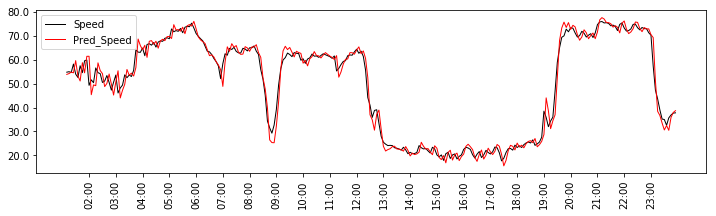

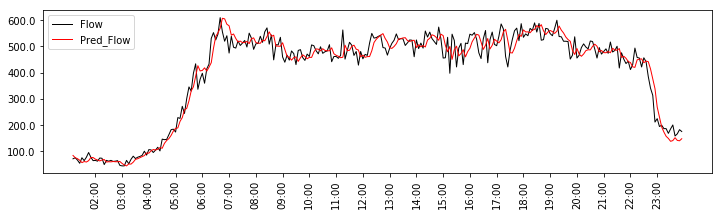

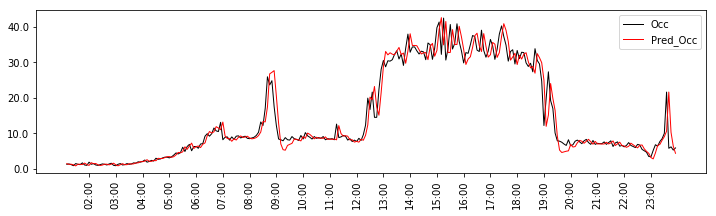

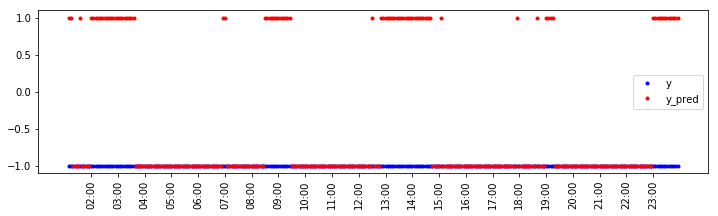

In [120]:
# randomly sample a base idx
rdn_idx = 274 * np.random.choice(int(X_test.shape[0] / 274))
rdn_end_idx = rdn_idx + 274
plot_time_series(X_test[rdn_idx:rdn_end_idx, 0], X_test[rdn_idx:rdn_end_idx, 3], 'Speed', 'Pred_Speed')
plot_time_series(X_test[rdn_idx:rdn_end_idx, 1], X_test[rdn_idx:rdn_end_idx, 4], 'Flow', 'Pred_Flow')
plot_time_series(X_test[rdn_idx:rdn_end_idx, 2], X_test[rdn_idx:rdn_end_idx, 5], 'Occ', 'Pred_Occ')
plot_detection(y_test[rdn_idx:rdn_end_idx], y_test_pred[rdn_idx:rdn_end_idx])